In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline


class JacksCarRentalEnvironment:
    
    TRANSFER_COST = 2
    RENTAL_INCOME = 10
    MAX_CAPACITY = 20
    REQUEST_RATE = (3,4)
    RETURN_RATE = (3,2)
    
    def __init__(self):
        self._carparkA = CarPark(3,3,type(self).MAX_CAPACITY)
        self._carparkB = CarPark(4,2,type(self).MAX_CAPACITY)
        print([self._carparkA.getObservation(),self._carparkB.getObservation()])
        
    def reset(self,val=None):
        self._carparkA = CarPark(3,3,type(self).MAX_CAPACITY,val)
        self._carparkB = CarPark(4,2,type(self).MAX_CAPACITY,val)
        print([self._carparkA.getObservation(),self._carparkB.getObservation()])
        
        
    def step(self,val):
        # val > 0 Autos wandern von A nach B
        # val < 0 Autos wandern von B nach A
        if val < 0:
            a = self._carparkB
            b = self._carparkA
            val = -1*val
        else:
            a = self._carparkA
            b = self._carparkB
        # Zu aller erst werden die autos von jack bewegt    
        # An einem Tag kommen zuerst Kunden und leihen Autos
        # Dann werden Autos zurückgegeben
        # Dann kann jack entscheiden welche autos bewegt werden
        # Einfachster Fall val == 0
        carsRented = 0
        reward = 0.0
        done = False
        if val == 0:
            carsRented += a.carsRenting()
            carsRented += b.carsRenting()
            reward = 10.0*carsRented
            # Bevor Autos kommen auf available pruefen oder spaeter
            if 0 in [self._carparkA.getObservation(),self._carparkB.getObservation()]:
                done = True
            a.carsArriving()
            b.carsArriving()
        else:
            availableCars = a.removeCars(val)
            reward = -2.0*val
            b.addCars(availableCars)
            carsRented += a.carsRenting()
            carsRented += b.carsRenting()
            reward = reward + 10.0*carsRented
            if 0 in [self._carparkA.getObservation(),self._carparkB.getObservation()]:
                done = True
            a.carsArriving()
            b.carsArriving()
        observation = [self._carparkA.getObservation(),self._carparkB.getObservation()]
        return (observation,reward,done,'')
    
    
    
class CarPark:
    
    def __init__(self, lamRequest, lamReturn, maxSize,val=None):
        self._lamRequest = lamRequest
        self._lamReturn = lamReturn
        self._maxSize = maxSize
        self._maxMove = 5
        if val == None:
            self._carsAvailable = np.random.randint(0,21,1)[0]
        else:
            self._carsAvailable = val
        
        
        
    def getObservation(self):
        return self._carsAvailable
    
    def carsArriving(self):
        r = np.random.poisson(self._lamReturn)
        if self._carsAvailable + r > self._maxSize:
            self._carsAvailable = self._maxSize
        else:
            self._carsAvailable += r
    
    def carsRenting(self):
        carsRented = np.random.poisson(self._lamRequest)
        if self._carsAvailable - carsRented < 0:
            carsRented = self._carsAvailable
            self._carsAvailable = 0
        else:
            self._carsAvailable -= carsRented
        return carsRented
           
    def addCars(self,amount):
        if amount > self._maxMove:
            raise Exception('Zu viele Autos')
        elif amount < 0:
            raise Exception('Du wolltest autos hinzufuegen')
        self._carsAvailable += amount
        if self._carsAvailable > self._maxSize:
            self._carsAvailable = self._maxSize
            
    def removeCars(self,amount):
        if amount > self._maxMove:
            raise Exception('Zu viele Autos')
        elif amount < 0:
            raise Exception('Du')
        if self._carsAvailable - amount < 0:
            amount = self._carsAvailable
            self._carsAvailable = 0
        else:
            self._carsAvailable -= amount
        return amount

In [2]:
class JacksCarRentalEnvironmentModel(JacksCarRentalEnvironment):
    
    def get_transition_probabilities_and_expected_reward(self, state, action):
        """
            Compute the $p(s', r\mid s,a)$
            Parameters
            ----------
            old_state: tuple of two ints
                the state (cars_at_A, cars_at_B)
            action: int
                nigthly movements of the cars as a int between -5 to 5, e.g.: 
                action +3: move three cars from A to B. 
                action -2: move two cars from B to A.
                
            Returns
            -------
            numpy array (2d - float): mapping from (new) states to probabilities
                index first dimension: cars at A
                index second dimension: cars at B
                value: probability  
            float:  expected reward for the state-action pair
        """
        #assert type(action) == int
        assert np.abs(action) <=5
        # first we move the cars in the night
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
            
        state = self._nightly_moves(state, action)
    
        expected_reward = - type(self).TRANSFER_COST * np.abs(action)
        expected_reward += self._expected_reward_rent(state)
        
        transition_probabilities = self._rent_transition_probabilities(state)
        transition_probabilities = self._returns_transition_probabilities(transition_probabilities)
        return transition_probabilities, expected_reward  
        
        
    def _nightly_moves(self, state, action):
        
        cars_at_A = state[0]
        cars_at_B = state[1]
        if action > 0:
            cars_moved = min(action, cars_at_A)
        else:
            cars_moved = max(action, -cars_at_B)
        
        cars_at_A = min(cars_at_A - cars_moved, type(self).MAX_CAPACITY)
        cars_at_B = min(cars_at_B + cars_moved, type(self).MAX_CAPACITY)
        return [cars_at_A, cars_at_B]
        
    def _expected_reward_rent(self, state):
        expected_reward_rent = 0.
        m = type(self).MAX_CAPACITY+1
        request_mu = type(self).REQUEST_RATE
        for i in (0,1):
            cars_at_loc = state[i]
            rv = scipy.stats.poisson(request_mu[i])
            rent_prob = (rv.pmf(range(m)))
            #logger.debug(rent_prob)
            rent_prob[cars_at_loc] = rent_prob[cars_at_loc:].sum()
            rent_prob[cars_at_loc+1:] = 0. 
            #logger.debug(rent_prob)
            expected_reward_rent += np.dot(np.arange(len(rent_prob)), rent_prob) * type(self).RENTAL_INCOME
        return expected_reward_rent
        
    def _rent_transition_probabilities(self, state):
        
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
        m = 15
        n = num_states_for_a_location + 2*m
        p_  = [np.zeros(n), np.zeros(n)]
        request_mu = type(self).REQUEST_RATE
        
        for i in (0,1):
            rv = scipy.stats.poisson(request_mu[i])
            cars_at_loc = state[i]
            x = cars_at_loc + m + 1     
            rent_prob = (rv.pmf(range(x)))
            assert state[i]-x+m+1 == 0
            p_[i][0:cars_at_loc+m+1] = rent_prob[::-1]
            p_[i][m] = p_[i][:m+1].sum()
            p_[i] = p_[i][m:-m]
        return p_
    
    def _returns_transition_probabilities(self, state_probalility):
        
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
        m=11
        n = num_states_for_a_location + 2*m
        returns_mu = type(self).RETURN_RATE
        p_  = [np.zeros(num_states_for_a_location), np.zeros(num_states_for_a_location)]
        for i in (0,1):
            rv = scipy.stats.poisson(returns_mu[i])
            #logger.debug(len(state_probalility[i]))
            for cars_at_loc in range(len(state_probalility[i])):
                p = np.zeros(n)
                #logger.debug(p.shape)
                x = num_states_for_a_location - cars_at_loc + m - 1     
                return_prob = (rv.pmf(range(x)))
                #logger.debug (p[cars_at_loc+m:-1].shape)
                p[cars_at_loc+m:-1] = return_prob
                #logger.debug(return_prob)
                p[num_states_for_a_location+m-1] = p[num_states_for_a_location+m-1:].sum()
                p = p[m:-m]
                #logger.debug(p)
                #logger.debug(p.sum())
                p_[i] += p * state_probalility[i][cars_at_loc]
        return p_
    

In [3]:
def updateV(s,v_Old,policy):
    # s ist (a,b)
    # γ = 1 = y
    y = 0.9 
    actions = np.arange(-5,6,1)
    # Summe ueber a gegeben S
    v_s = 0
    pol_forState = policy[s[0],s[1]]
    for i in range(len(actions)):
        act = actions[i]
        pol_a_s = pol_forState[i] 
        stateprobs, r_a = jack.get_transition_probabilities_and_expected_reward(s,act)
        # Summe ueber alle S' gegeben a
        q_a_SPrime = 0
        for carA in range(len(stateprobs[0])):
            for carB in range(len(stateprobs[1])):
                prob_of_State_prime = stateprobs[0][carA] * stateprobs[1][carB]
                q_a_SPrime += prob_of_State_prime * v_Old[carA,carB]  
        v_s += pol_a_s * ( r_a + y * q_a_SPrime)
    return v_s


def updateV_Synchron(v_Old,policy):
    v_new = np.zeros((21,21))
    for stateA in range(len(v_Old)):
        for stateB in range(len(v_Old[stateA])):
            state = (stateA,stateB)
            v_new[stateA,stateB] = updateV(state,v_Old,policy)
    return v_new

def doPolicyEvaluation(v_Old, policy):
    ## Dauert zu Lange
    v_new = updateV_Synchron(v_Old,policy)
    counter = 1
    diff = np.max(np.abs(v_Old-v_new))
    while diff > 0.1 and counter < 50 :
        print(str(counter) + ' Updates of V, max difference to last: ' + str(diff))
        counter += 1
        v_Old = v_new
        v_new = updateV_Synchron(v_Old,policy)
        diff = np.max(np.abs(v_Old-v_new))
    if diff <= 0.1:
        print(str(counter) + ' Updates of V, max difference to last was less 0.1')
    else: 
        print(str(counter) + ' Stoped after 50 Updates of V')
    return v_new

# Improve policy by acting greedy
def policyImprovement(v_new):
    policiy_new = np.zeros((21,21,11))
    carA, carB = 21, 21
    for carA_I in range(carA):
        for carB_I in range(carB):
            best_act, best_actIndex = oneStepLookAHead((carA_I,carB_I),v_new)
            policiy_new[carA_I,carB_I,best_actIndex] = 1
    return policiy_new


def oneStepLookAHead(s,v_new):
    # s ist (a,b)
    # γ = 1 = y
    # Fuer alle Aktionen expected Reward berechnen
    y = 1
    temp = 0 # sum
    actions = np.arange(-5,6,1)
    q_a = np.zeros(len(actions))
    for i in range(len(actions)):
        act = actions[i] 
        stateprobs, r_a = jack.get_transition_probabilities_and_expected_reward(s,act)
        # Summe ueber alle S'
        temp_a = 0
        for carA in range(len(stateprobs[0])):
            for carB in range(len(stateprobs[1])):
                prob_of_State_prime = stateprobs[0][carA] * stateprobs[1][carB]
                temp_a += prob_of_State_prime * v_new[carA,carB]  
        q_a[i] = r_a + y * temp_a
        
    best_actIndex = np.argmax(q_a)
    best_act = actions[best_actIndex]
    
    return best_act, best_actIndex

In [4]:
jack = JacksCarRentalEnvironmentModel()
v_old = np.zeros((21,21)) 
policy = np.zeros((21,21,11))
policy.fill(1/11)
#v_new = doPolicyEvaluation(v_old, policy)

[5, 17]


In [41]:
v_new2 = doPolicyEvaluation(v_new, policy)

1 Updates of V, max difference to last: 16.6254972301
2 Updates of V, max difference to last: 14.7156340864
3 Updates of V, max difference to last: 13.0624558824
4 Updates of V, max difference to last: 11.6223792479
5 Updates of V, max difference to last: 10.361218549
6 Updates of V, max difference to last: 9.2517615825
7 Updates of V, max difference to last: 8.2720577183
8 Updates of V, max difference to last: 7.40418382888
9 Updates of V, max difference to last: 6.63333822145
10 Updates of V, max difference to last: 5.94716619349
11 Updates of V, max difference to last: 5.33525285283
12 Updates of V, max difference to last: 4.78873848938
13 Updates of V, max difference to last: 4.30002450572
14 Updates of V, max difference to last: 3.86254661904
15 Updates of V, max difference to last: 3.4705982465
16 Updates of V, max difference to last: 3.11919150043
17 Updates of V, max difference to last: 2.80394653328
18 Updates of V, max difference to last: 2.52100240919
19 Updates of V, max di

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

MAX_CAPACITY = 20

def plot3d_over_states(f, zlabel="", ):
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    # B, A !!!
    B, A = np.meshgrid(B, A)
    V = f.reshape(MAX_CAPACITY+1,-1)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax = fig.gca(projection='3d')
    #surf = ax.plot_surface(A, B, V, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                   linewidth=0, antialiased=False)
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.scatter(A, B, V, c='b', marker='.')
    ax.set_xlabel("cars at A")
    ax.set_ylabel("cars at B")
    ax.set_zlabel(zlabel)
 
    #ax.view_init(elev=10., azim=10)
    
    plt.show()

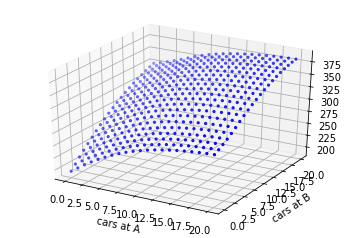

In [37]:
plot3d_over_states(v_new)

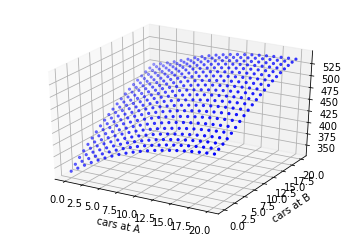

In [47]:
plot3d_over_states(v_new2)

In [43]:
import pickle

In [45]:
pickle.dump( v_new, open( r'/Users/johannesthurn/Documents/HTW/WissRep/v.p', 'wb' ) )

In [48]:
np.max(np.abs(v_new-v_new2))

154.47936566418554

In [5]:
policy

array([[[ 0.09090909,  0.09090909,  0.09090909, ...,  0.09090909,
          0.09090909,  0.09090909],
        [ 0.09090909,  0.09090909,  0.09090909, ...,  0.09090909,
          0.09090909,  0.09090909],
        [ 0.09090909,  0.09090909,  0.09090909, ...,  0.09090909,
          0.09090909,  0.09090909],
        ..., 
        [ 0.09090909,  0.09090909,  0.09090909, ...,  0.09090909,
          0.09090909,  0.09090909],
        [ 0.09090909,  0.09090909,  0.09090909, ...,  0.09090909,
          0.09090909,  0.09090909],
        [ 0.09090909,  0.09090909,  0.09090909, ...,  0.09090909,
          0.09090909,  0.09090909]],

       [[ 0.09090909,  0.09090909,  0.09090909, ...,  0.09090909,
          0.09090909,  0.09090909],
        [ 0.09090909,  0.09090909,  0.09090909, ...,  0.09090909,
          0.09090909,  0.09090909],
        [ 0.09090909,  0.09090909,  0.09090909, ...,  0.09090909,
          0.09090909,  0.09090909],
        ..., 
        [ 0.09090909,  0.09090909,  0.09090909, ...,

In [6]:
def policyIteration(v_old, policy_act):
    v_new = updateV_Synchron(v_old,policy_act)
    
    
    policyChanged = True
    counter = 1
    diffPol_L = list()
    while policyChanged:
        print('Iteration: ' + str(counter))
        v_old = v_new
        v_new = updateV_Synchron(v_old,policy_act)
        policy_test = policy_act
        policy_act = policyImprovement(v_new)
        diff = np.max(np.abs(v_old-v_new))
        test = np.allclose(policy_act,policy_test)
        counter += 1
        if test:
            policyChanged = False
        diffPol_L.append((diff,policy_act))
    return v_new, policy_act, diffPol_L
    
        
        

In [8]:
v,p, diffPol_L = policyIteration(v_old,policy)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11


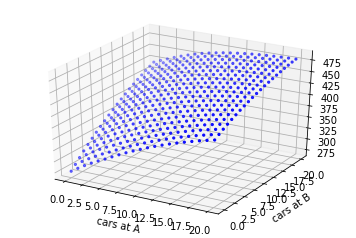

In [11]:
plot3d_over_states(v)

In [23]:
def plot_policy(policy):
    MAX_CAPACITY = 20
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    A, B = np.meshgrid(A, B)
    Po = policy.reshape(MAX_CAPACITY+1,-1)
    levels = range(-5,6,1)
    plt.figure(figsize=(7,6))
    CS = plt.contourf(A, B, Po, levels)
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('actions')
    #plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Policy')
    plt.xlabel("cars at B")
    plt.ylabel("cars at A")

In [13]:
pol = p.copy()

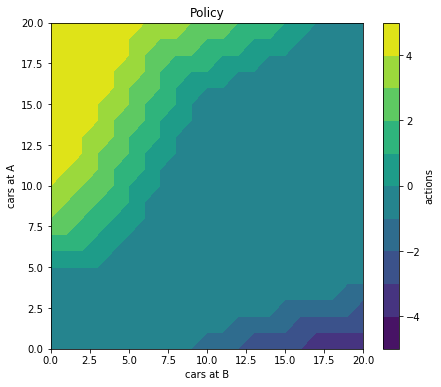

In [14]:
pol.reshape(21,-1)
pol = np.argmax(pol,axis=2)
plot_policy(pol-5)

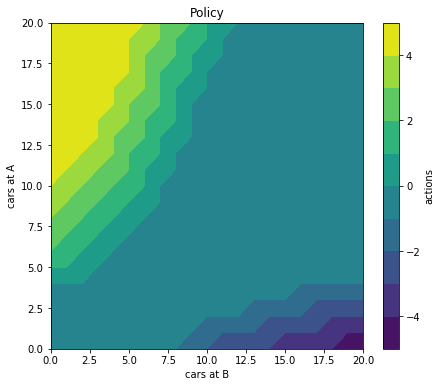

In [19]:
pol_4 = diffPol_L[3][1]
pol_4.reshape(21,-1)
pol_4 = np.argmax(pol_4,axis=2)
plot_policy(pol_4-5)

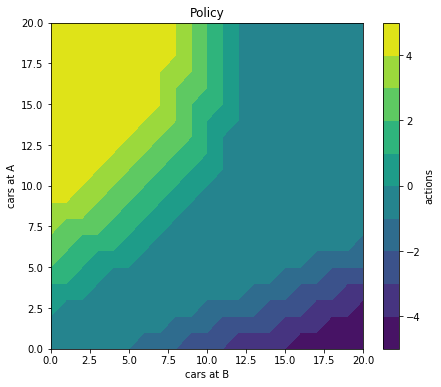

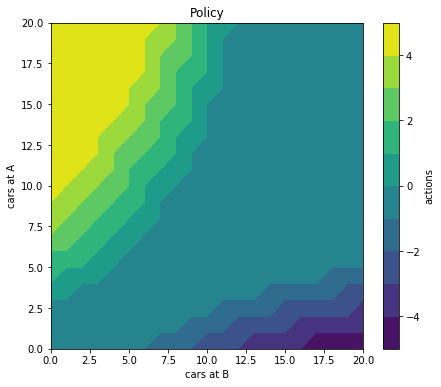

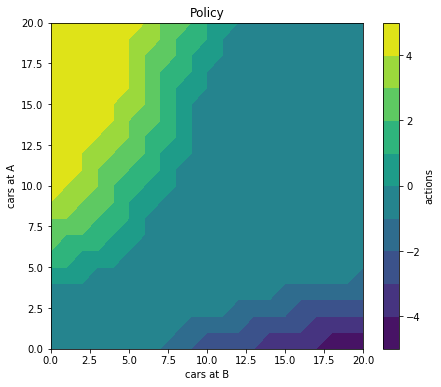

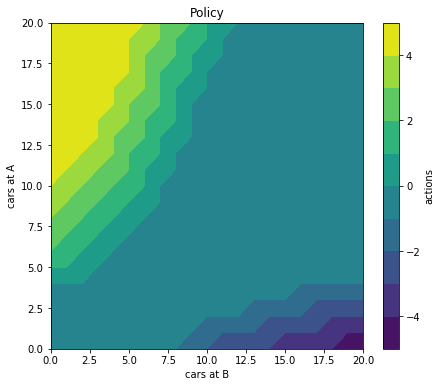

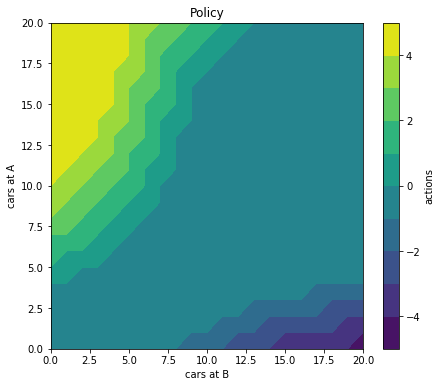

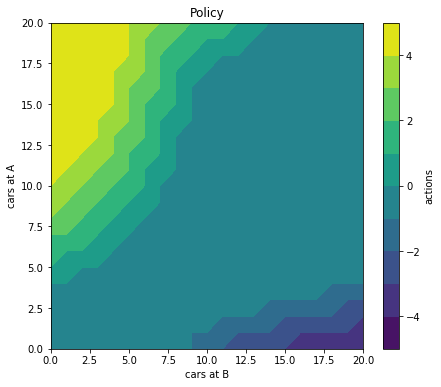

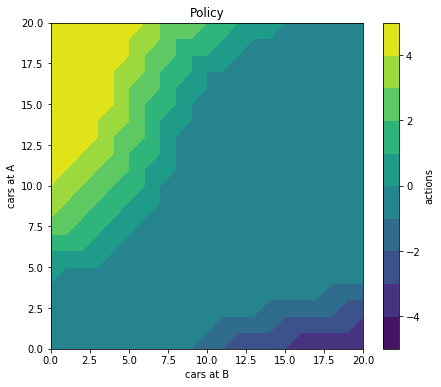

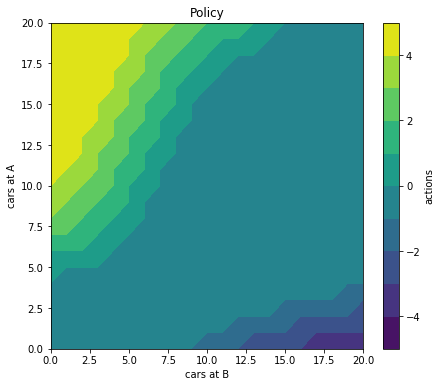

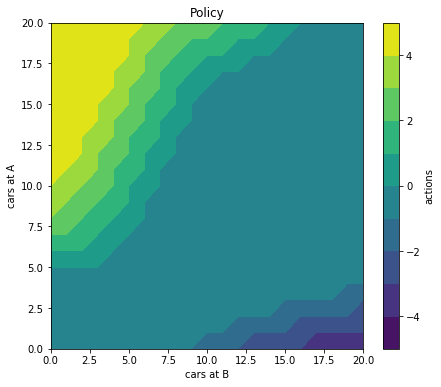

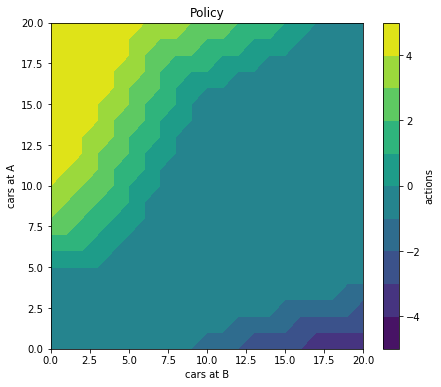

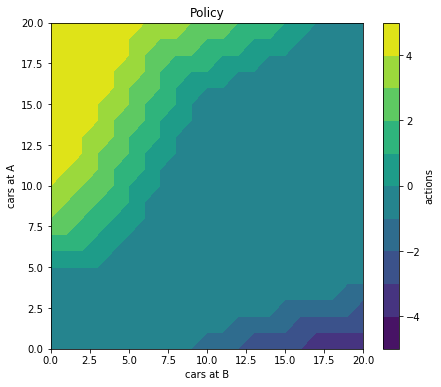

In [24]:
for diff,pol in diffPol_L:
    pol = pol.copy()
    pol.reshape(21,-1)
    pol = np.argmax(pol,axis=2)
    plot_policy(pol-5)

In [25]:
pol

array([[ 5,  5,  5,  5,  5,  5,  5,  5,  5,  4,  4,  3,  3,  3,  2,  2,  2,
         2,  1,  1,  1],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  4,  4,  4,  3,  3,  3,  3,
         2,  2,  2,  2],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  4,  4,  4,  4,  3,
         3,  3,  3,  3],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  4,  4,
         4,  4,  4,  3],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  4,  4],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5],
       [ 6,  6,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5],
       [ 7,  7,  7,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5],
       [ 8,  8,  7,  7,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5],
       [ 9,  8,  8,  7,  7,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,